In [20]:
include("Compologicircuits.jl")

Main.Compologicircuits

In [52]:
using ..Compologicircuits
using Catlab.Programs
using Catlab.WiringDiagrams
using Catlab.Present
using Catlab.Theories
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.CategoricalAlgebra
using Catlab.Syntax
using MLStyle

In [22]:
Circuits

Presentation{CartesianCategory, Symbol}(Catlab.Theories.FreeCartesianCategory, (Ob = Catlab.Theories.FreeCartesianCategory.Ob{:generator}[B], Hom = Catlab.Theories.FreeCartesianCategory.Hom{:generator}[NOT, AND, OR]), Dict(:NOT => (:Hom => 1), :B => (:Ob => 1), :AND => (:Hom => 2), :OR => (:Hom => 3)), Pair[])

Define an XOR circuit programatically

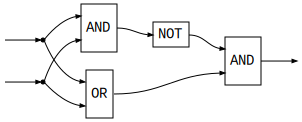

In [23]:
#Wiring Diagram representation of XOR
XOR = @program Circuits (x::B, y::B) begin
    xnandy = NOT(AND(x,y))
    xory = OR(x,y)
    return AND(xnandy,xory)
end

show_diagram(XOR)

In [24]:
XOR_expr = to_hom_expr(FreeCartesianCategory, XOR)

(mcopy{B}⊗mcopy{B})⋅(id{B}⊗braid{B,B}⊗id{B})⋅((AND⋅NOT)⊗OR)⋅AND: B⊗B → B

In [25]:
#Implement XOR diagram
iXOR = Impl(XOR_expr)
#Print XOR truth table
aiXOR = Augmented_Circuit(iXOR)
aiXOR.sol

4-element Vector{Vector{Vector{Bool}}}:
 [[0, 0], [0]]
 [[1, 0], [1]]
 [[0, 1], [1]]
 [[1, 1], [0]]

In [26]:
@present MoreCircuits <: Circuits begin
    XOR::Hom(B⊗B,B)
    FA::Hom(B⊗B⊗B,B⊗B)
end

Presentation{CartesianCategory, Symbol}(Catlab.Theories.FreeCartesianCategory, (Ob = Catlab.Theories.FreeCartesianCategory.Ob{:generator}[B], Hom = Catlab.Theories.FreeCartesianCategory.Hom{:generator}[NOT, AND, OR, XOR, FA]), Dict(:NOT => (:Hom => 1), :FA => (:Hom => 5), :B => (:Ob => 1), :AND => (:Hom => 2), :OR => (:Hom => 3), :XOR => (:Hom => 4)), Pair[])

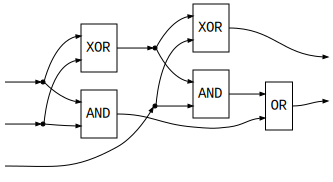

In [27]:
full_adder = @program MoreCircuits (x::B, y::B, cin::B) begin
    z = XOR(x,y)
    s = XOR(z,cin)
    cout = OR(AND(z,cin),AND(x,y))
    return (s, cout)
end

show_diagram(full_adder)

In [28]:
nboxes(full_adder)

5

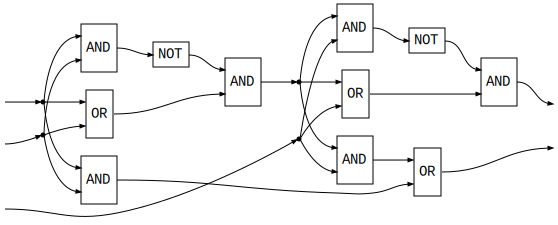

In [29]:
AND = to_wiring_diagram(MoreCircuits[:AND])
NOT = to_wiring_diagram(MoreCircuits[:NOT])
OR = to_wiring_diagram(MoreCircuits[:OR])
total_full_adder = ocompose(full_adder, [XOR, XOR, AND, AND, OR])
show_diagram(total_full_adder)

In [30]:
iFA = Impl(to_hom_expr(FreeCartesianCategory, total_full_adder))
aiFA = Augmented_Circuit(iFA)
aiFA.sol

8-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0], [0, 0]]
 [[1, 0, 0], [1, 0]]
 [[0, 1, 0], [1, 0]]
 [[1, 1, 0], [0, 1]]
 [[0, 0, 1], [1, 0]]
 [[1, 0, 1], [0, 1]]
 [[0, 1, 1], [0, 1]]
 [[1, 1, 1], [1, 1]]

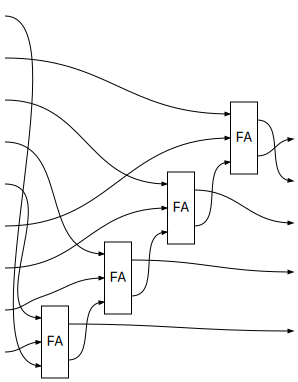

In [31]:
four_bit_adder = @program MoreCircuits (cin::B, x1::B, x2::B, x3::B, x4::B, y1::B, y2::B, y3::B, y4::B) begin
    s1, cout1 = FA(x4,y4,cin)
    s2, cout2 = FA(x3,y3,cout1)
    s3, cout3 = FA(x2,y2,cout2)
    s4, cout = FA(x1,y1,cout3)
    return (cout, s4, s3, s2, s1)
end

show_diagram(four_bit_adder)

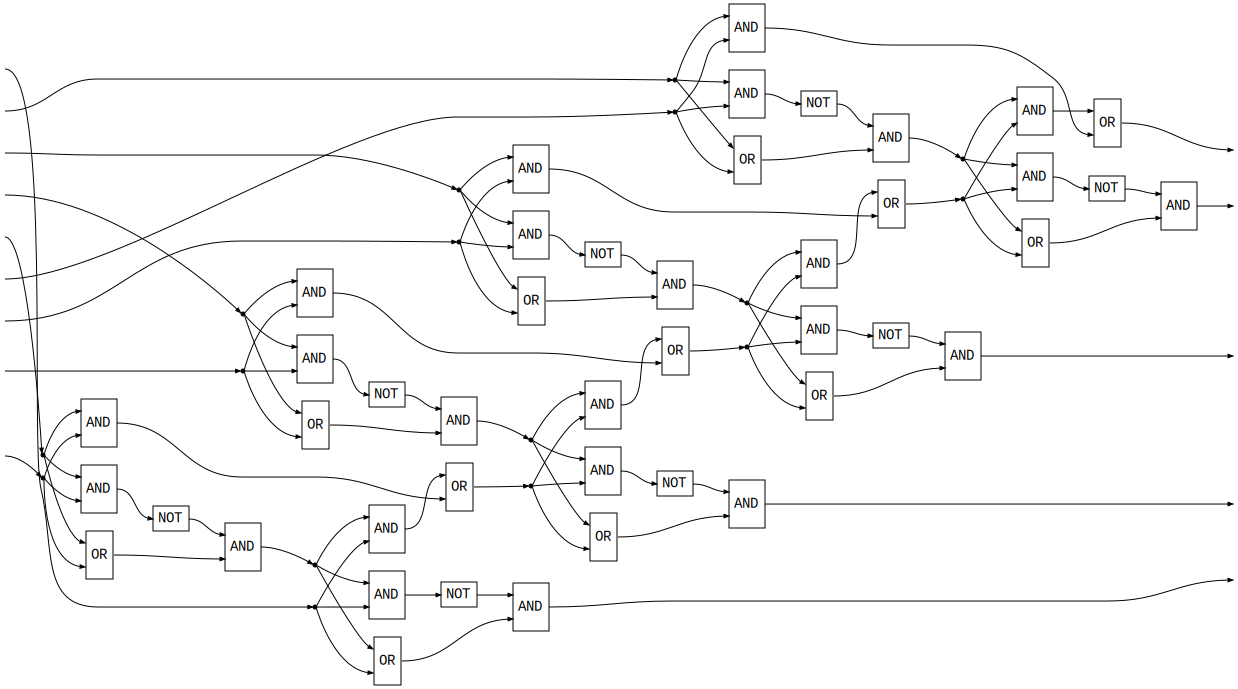

In [32]:
total_four_bit_adder = ocompose(four_bit_adder, [total_full_adder, total_full_adder, total_full_adder, total_full_adder])
show_diagram(total_four_bit_adder)

In [33]:
tfba_expr = to_hom_expr(FreeCartesianCategory, total_four_bit_adder)
i4bitadder = Impl(tfba_expr)

Circuit(CircuitDom(9), CircuitDom(5), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(10), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(10), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit, Circuit}(Circuit(CircuitDom(9), CircuitDom(19), Main.Compologicircuits.var"#10#19"{Circuit

## Sub-Circuit Picking

### Motivation

Imagine that your company X-Corp has implemented a circuit design for some product. A sales-person from Y-Corp is advertising their circuit product, claiming that your board could use their product as a sub-circuit module. How do you verify this claim?

### Background

We define the problem of finding a sub-circuit *Y* in some circuit *X* as finding natural transformations from *Y* to *X*. However, for the purposes of finding sub-circuits, we must treat wires at the edge of the circuit the same way as we treat wires on the inside of a circuit. That is, we must define a functor from this simpler type of wiring diagram to our regular wiring diagram. We then take the DeltaMigration of this functor, which gives us a so-called ``forgetful'' functor from the wiring diagram ACSets that we are used to to these simpler wiring diagram ACSets. We can then then use this forgetful functor on our circuit diagrams to simplify them. We can then use Catlab's homomorphisms function to find sub-circuits for us.

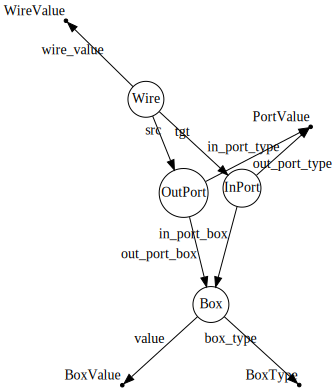

In [34]:
@present TheoryNotOpenWiringDiagram(FreeSchema) begin
    Box::Ob
    (InPort, OutPort)::Ob
    Wire::Ob

    # Finding sub-circuits must work whether the sub-circuit is located on the inside or on the edge of the larger circuit.
    #(OuterInPort, OuterOutPort)::Ob
    #(InWire, OutWire)::Ob

    PortValue::AttrType
    WireValue::AttrType
    BoxValue::AttrType
    BoxType::AttrType

    # To which in/out port is a wire attached?
    src::Hom(Wire, OutPort)
    tgt::Hom(Wire, InPort)

    in_port_type::Attr(InPort, PortValue)
    out_port_type::Attr(OutPort, PortValue)

    value::Attr(Box, BoxValue)
    box_type::Attr(Box, BoxType)
    wire_value::Attr(Wire, WireValue)
    #in_wire_value::Attr(InWire, WireValue)
    #out_wire_value::Attr(OutWire, WireValue)

    #in_tgt::Hom(InWire, InPort)
    #out_src::Hom(OutWire, OutPort)

    # To which box is an in/out port attached?
    in_port_box::Hom(InPort, Box)
    out_port_box::Hom(OutPort, Box)
end

to_graphviz(TheoryNotOpenWiringDiagram)

In [35]:
F = @finfunctor TheoryNotOpenWiringDiagram DirectedWiringDiagrams.TheoryAttributedWiringDiagram begin
    Box => Box
    InPort => InPort
    OutPort => OutPort
    Wire => Wire

    PortValue => PortValue
    WireValue => WireValue
    BoxValue => BoxValue
    BoxType => BoxType

    src => src
    tgt => tgt

    in_port_type => in_port_type
    out_port_type => out_port_type

    value => value
    box_type => box_type
    wire_value => wire_value

    in_tgt => in_tgt
    out_src => out_src

    in_port_box => in_port_box
    out_port_box => out_port_box
end

FinFunctor(Dict{Symbol, Catlab.Syntax.GATExpr{:generator}}(:InPort => InPort, :WireValue => WireValue, :Wire => Wire, :PortValue => PortValue, :BoxType => BoxType, :Box => Box, :BoxValue => BoxValue, :OutPort => OutPort), Dict{Symbol, Catlab.Syntax.GATExpr{:generator}}(:src => src, :value => value, :in_port_box => in_port_box, :wire_value => wire_value, :out_port_box => out_port_box, :box_type => box_type, :in_port_type => in_port_type, :tgt => tgt, :out_port_type => out_port_type), FinCat(Presentation{Schema, Symbol}(Catlab.Theories.FreeSchema, (Ob = Catlab.Theories.FreeSchema.Ob{:generator}[Box, InPort, OutPort, Wire], Hom = Catlab.Theories.FreeSchema.Hom{:generator}[src, tgt, in_port_box, out_port_box], AttrType = Catlab.Theories.FreeSchema.AttrType{:generator}[PortValue, WireValue, BoxValue, BoxType], Attr = Catlab.Theories.FreeSchema.Attr{:generator}[in_port_type, out_port_type, value, box_type, wire_value]), Dict(:InPort=>(:Ob=>2), :WireValue=>(:AttrType=>2), :in_port_box=>(:Hom=

In [36]:
@acset_type NOWDACSet(TheoryNotOpenWiringDiagram)

deltaF = DeltaMigration(F, NOWDACSet{Any, Any, Any, DataType})

cAND = deltaF(AND.diagram)
cOR = deltaF(OR.diagram)
cNOT = deltaF(NOT.diagram)
cXOR = deltaF(XOR.diagram)

Box,value,box_type
1,AND,Box{Symbol}
2,NOT,Box{Symbol}
3,OR,Box{Symbol}
4,AND,Box{Symbol}
InPort,in_port_box,in_port_type
1,1,B
2,1,B
3,2,B
4,3,B
5,3,B


In [37]:
## Pick out AND's in AND.
println("There are ", length(homomorphisms(cAND, cAND, monic=true)), " monic homomorphisms from AND to AND.")

## Pick out OR's in AND.
println("There are ", length(homomorphisms(cOR, cAND, monic=true)), " monic homomorphisms from OR to AND.")

# Pick out AND's in XOR.
println("There are ", length(homomorphisms(cAND, cXOR, monic=true)), " monic homomorphisms from AND to XOR.")

# Pick out circuits in total_four_bit_adder that can be replaced by FA's.
println("There are ", length(homomorphisms(deltaF(total_full_adder.diagram),
    deltaF(total_four_bit_adder.diagram), monic=true)),
    " monic homomorphisms from total_full_adder to total_four_bit_adder.")

There are 2 monic homomorphisms from AND to AND.
There are 0 monic homomorphisms from OR to AND.
There are 4 monic homomorphisms from AND to XOR.
There are 32 monic homomorphisms from total_full_adder to total_four_bit_adder.


Let us look at a few of the sub-circuits that we found.

In [40]:
homomorphisms(cAND, cAND, monic=true)[begin] # This is trivial.

ACSetTransformation((Box = FinFunction([1], 1, 1), InPort = FinFunction([1, 2], 2, 2), OutPort = FinFunction([1], 1, 1), Wire = FinFunction(Int64[], 0, 0)), NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0}, NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0})

In [42]:
homomorphisms(cAND, cAND, monic=true)[end] # Notice how the in-ports are switched here.

ACSetTransformation((Box = FinFunction([1], 1, 1), InPort = FinFunction([2, 1], 2, 2), OutPort = FinFunction([1], 1, 1), Wire = FinFunction(Int64[], 0, 0)), NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0}, NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0})

Here, we see that we can pick out the total full adder sub-circuits in the total four-bit adder circuit. Hover over the boxes in the total four-bit adder circuit diagram above and see how the Box FinFunction here maps to the appropriate boxes in the last full adder in that circuit.

In [46]:
homomorphisms(deltaF(total_full_adder.diagram), deltaF(total_four_bit_adder.diagram), monic=true)[end]

ACSetTransformation((Box = FinFunction([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 11, 44), InPort = FinFunction([62, 61, 63, 65, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 77, 79, 80], 20, 80), OutPort = FinFunction([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 11, 44), Wire = FinFunction([36, 38, 52, 16, 20, 1, 2, 3, 15, 33, 51], 11, 53)), NOWDACSet {Box = 11, InPort = 20, OutPort = 11, Wire = 11}, NOWDACSet {Box = 44, InPort = 80, OutPort = 44, Wire = 53})

<h1>Circuit Satisfiability</h1>

By the Cook-Levin theorem, the infamous SAT problem is NP-complete, and its anology in circuits, CIRCUIT-SAT, is also NP-complete (they have polynomial time reductions to each other). Circuits provide a different perspective to boolean formulas, some believe that it provides a convenient computational model for attacking P vs NP (Introduction to the Theory of Computation, Sipser, third edition, section 9.3). One immediate observation is that if a circuit has no copy gates, then it is satisfiable, so we can define the following function succinctly using the ```@match``` macro going down the syntax tree of a circuit expression to see if any node contains a copy gate.

In [25]:
B = Circuits[:B]
not = Circuits[:NOT]
and = Circuits[:AND]
or = Circuits[:OR]
demo1 = (mcopy(B)⊗mcopy(B))⋅(not⊗σ(B,B)⊗not)⋅(and⊗and)⋅and
demo2 = (not⊗σ(B,B)⊗not)⋅(and⊗and)⋅or

#if mcopy is never used then the circuit has all possible outputs, hence satisfiable
#returns true if contains mcopy, otherwise return false
vibe_check(expr::FreeCartesianCategory.Hom)::Bool =
    @match head(expr) begin
        :mcopy => true
        :compose || :otimes => any(map(vibe_check, args(expr)))
        _ => false
    end

[vibe_check(demo1), vibe_check(demo2)]

2-element Vector{Bool}:
 1
 0

Here's what the circuits looks like in diagram.

<h2>Proo sketch:</h2>
By strong induction on $P_{n}$ := circuits that use $n$ gates taken from the collection $and, or, not, copy, braid, idhave all possible outputs.

Base case show $P_1$ holds:
the logic gates $and, or, not$ can output true or false. The gates copy, braid, and id also have all possible outputs.

Inductive case, suppose $P_{n}$ holds for all $n \in [1, k]$ for some $k \geq 1$: 
to obtain a circuit using $k+1$ gates, we can either :compose two smaller circuits, or :otimes two smaller circuits, either way, the smaller circuits have all possible outputs, so it implies that vertically or horizontally composing them returns a circuit with all possible outputs.

                                                                                                                    QED

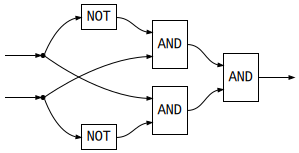

In [26]:
show_diagram(to_wiring_diagram(demo1))

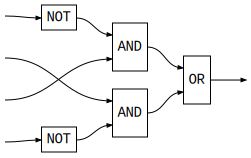

In [27]:
show_diagram(to_wiring_diagram(demo2))

Another way to see this: when we consider an equivalent $CNF$ formula to a circuit, we notice if a variable is never used more than once, then we can manipulate that variable's corresponding literal to output true, so we will have a conjunct of disjunct of trues. Note that our circuit models actually give a strong and more general statement than this, since circuits may have an array of outputs and $P_n$ is more general than just "satisfiable" anyway. The following shows that ```demo2``` is actually satisfiable and returns a true assignment to ```demo2```, note that having copy gates says nothing about satsfiability, so ```demo1``` not being satisfiable is only a coincidence. 

In [28]:
brute_SAT(demo1)

(false, Bool[0, 0])

In [29]:
brute_SAT(demo2)

(true, Bool[0, 1, 1, 1])

```brute_SAT(expr)``` returns a pair ```(x::Bool,y::BitVector)```, where ```x``` says whether ```expr``` is satisfiable, if so ```x == true``` and ```y``` is the first satisfying assignment it finds, if not then ```x == false```



Compologicircuits in fact has a function that takes in an expression of the type ```FreeCartesianCategory.Hom``` and returns an equivalent $CNF$ formula stored as a ector of vector of nonzero integers. Let's see what the $CNF$'s of ```demo1``` and ```demo2``` are:

In [30]:
cnf1 = expr_to_cnf(demo1)

([2, 4], Vector{Any}[[-2], [2], [4], [-4]], 1, 2)

In [31]:
cnf2 = expr_to_cnf(demo2)

([1, 2, 3, 4], Vector{Any}[[-1, 3], [-1, -4], [2, 3], [2, -4]], 1, 4)

Note that the actual output is a tuple of size 4, the actual $CNF$ is the second element, the rest are parameters that are used in the implementation of the algorithm that uses recursive calls and its action depends on these parameters. The parameters are still meaningful, the following lists what they are

| ```expr_to_cnf(expr)```      | what is it? |
| :---        |    :----:   |
| 1st element      | the assignment of the variables on the input wires      |
| 2nd element   | equivalent $CNF$       |
| 3rd element   | where to start applying the input wires        |
| 4th element  | number of input wires        |

As expected, the $CNF$ of ```demo1``` uses variables multiples times, but this is also true for ```demo2```, the reason is that it is merely _possible_ to express ```demo2``` with a $CNF$ that uses no variable more than once, however as we will see using a more conventional SAT solver PicoSAT, that ```cnf2[2]``` is satisfiable just like ```demo2```

In [32]:
using PicoSAT
solution = PicoSAT.solve(cnf2[2])

4-element Vector{Int64}:
 -1
  2
  3
 -4

In [33]:
Impl(demo2).impl(map(x -> x > 0, solution))

1-element Vector{Bool}:
 1

The structure ```Augmented_Circuit``` has two fields, ```circ``` is the circuit and ```sol``` the "solution space" A.K.A. its truth table, consider the following two examples, demo2 indeed outputs ```true``` for input ```Bool[0,1,1,0]```

In [36]:
Augmented_Circuit((Impl(demo2))).sol

16-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0], [0]]
 [[1, 0, 0, 0], [0]]
 [[0, 1, 0, 0], [1]]
 [[1, 1, 0, 0], [1]]
 [[0, 0, 1, 0], [1]]
 [[1, 0, 1, 0], [0]]
 [[0, 1, 1, 0], [1]]
 [[1, 1, 1, 0], [1]]
 [[0, 0, 0, 1], [0]]
 [[1, 0, 0, 1], [0]]
 [[0, 1, 0, 1], [0]]
 [[1, 1, 0, 1], [0]]
 [[0, 0, 1, 1], [1]]
 [[1, 0, 1, 1], [0]]
 [[0, 1, 1, 1], [1]]
 [[1, 1, 1, 1], [0]]

In [47]:
tfba_ex = to_hom_expr(FreeCartesianCategory, total_four_bit_adder)
Augmented_Circuit(Impl(tfba_ex)).sol

512-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
 [[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1]]
 [[0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0]]
 [[1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1]]
 [[0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0]]
 [[1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1]]
 [[0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0]]
 [[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1]]
 [[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0]]
 [[1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1]]
 [[0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0]]
 [[1, 1, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1]]
 [[0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0]]
 ⋮
 [[0, 0, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0]]
 [[1, 0, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 1]]
 [[0, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0]]
 [[1, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1]]
 [[0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 0]]
 [[1, 0, 0, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 1]]
 [[0, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 0, 1,

Note that SAT and $CNF$ both make no sense for ```total_four_bit_adder```, so we get an error

In [48]:
brute_SAT(tfba_ex)

LoadError: circuit codomain needs to be 1!

In [49]:
expr_to_cnf(tfba_ex)

LoadError: AssertionError: (Impl(expr)).codom.n == 1

Just for fun, here's the truth table for a terrible terrible circuit

In [50]:
terror = (tfba_ex ⊗ tfba_ex) ⋅ (tfba_ex ⊗ id(B)) ⋅ (and⊗or⊗or) ⋅(σ(B, B⊗B)) ⋅ (and⊗not) ⋅ and

((((mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B}))⊗(mcopy{B}⋅(mcopy{B}⊗id{B})))⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B}⊗id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B})⋅(id{B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B⊗B}⊗braid{B,B

In [52]:
@time brute_SAT(terror)

  0.021217 seconds (328.55 k allocations: 12.106 MiB)


(true, Bool[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
#@time Augmented_Circuit(Impl(terror)).sol
#=
157.751749 seconds (2.28 G allocations: 210.128 GiB, 20.60% gc time)

262144-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 ⋮
 [[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]
 [[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]
 [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]
 [[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]
 [[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]
 [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]
#=

169.301849 seconds (2.28 G allocations: 210.128 GiB, 21.45% gc time)


262144-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 ⋮
 [[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[0, 1

It wasn't that bad to find a satisfying assignment for ```terror```, but it was terrible to compute its truth table, because there are $2^{18} = 262144$ number of rows! Rather than storing this information as a truth table then, we can do a binary decision tree.